## Diagnóstico de un modelo de regresión lineal

Una vez que se ajusta un modelo de regresión lineal, no basta con observar los coeficientes y el R² para determinar si el modelo es adecuado. Es fundamental realizar una serie de **diagnósticos estadísticos** que permitan evaluar si se cumplen los supuestos del modelo y si los resultados obtenidos son válidos y confiables.

El proceso de diagnóstico tiene los siguientes objetivos:

1. **Verificar los supuestos clásicos de la regresión OLS:**
   - Linealidad
   - Independencia de los errores
   - Homocedasticidad (varianza constante de los errores)
   - Normalidad de los errores
   - No multicolinealidad entre variables explicativas

2. **Detectar observaciones problemáticas:**
   - Outliers
   - Valores de alta influencia o apalancamiento

3. **Evaluar la estabilidad y robustez del modelo**

---

### Herramientas comunes de diagnóstico

- **Gráficos de residuos:**
  - Residuos vs valores ajustados
  - Q-Q plot de normalidad
  - Residuos vs predictores
- **Estadísticos diagnósticos:**
  - Durbin-Watson (autocorrelación)
  - Breusch-Pagan / White (heterocedasticidad)
  - Variance Inflation Factor (VIF, multicolinealidad)
  - Cook’s Distance y leverage (influencia)

Un modelo que viola sus supuestos puede producir:
- **Coeficientes sesgados o ineficientes**
- **Errores estándar incorrectos**
- **Intervalos de confianza y valores p no confiables**

En resumen, **los diagnósticos son una parte esencial del análisis de regresión**. No se trata solo de ajustar un modelo, sino de asegurarse de que sus resultados puedan interpretarse y utilizarse con confianza.


## Importación de librerías

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.compat import lzip
# Importa la función lzip, una versión compatible con Python 2 y 3 de zip, usada frecuentemente en resúmenes de resultados estadísticos.
# Se utiliza comúnmente para emparejar nombres de estadísticas con sus valores en listas legibles.
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
# Importa el submódulo utilizado para pruebas estadísticas (diagnósticos)
from statsmodels.stats.outliers_influence import OLSInfluence
# Importa la clase OLSInfluence, que permite analizar la influencia de cada observación en un modelo OLS ajustado.
# Proporciona métricas diagnósticas como:
# - Leverage (apalancamiento)
# - Residuos estandarizados
# - Distancia de Cook (Cook’s Distance)
# - DFFITS y DFBetas (influencia en predicción y en coeficientes)
# Esto es útil para identificar observaciones influyentes, atípicas o con gran efecto en el ajuste del modelo.
from statsmodels.graphics.regressionplots import plot_leverage_resid2
# Importa la función plot_leverage_resid2 del módulo de gráficos de regresión de statsmodels.
# Esta función genera un gráfico que combina:
# - El leverage (influencia estructural de cada observación) en el eje x,
# - Los residuos studentizados (residuos externos) en el eje y.

## Importación de datos

In [2]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df.head()

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,Wealth,Commerce,Clergy,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
0,1,E,Ain,28870,15890,37,5098,33120,35039,2:Med,73,58,11,71,60,69,41,55,46,13,218.372,5762,346.03
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2:Med,22,10,82,4,82,36,38,82,24,327,65.945,7369,513.00
2,3,C,Allier,26747,7925,13,10973,17044,114121,2:Med,61,66,68,46,42,76,66,16,85,34,161.927,7340,298.26
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1:Sm,76,49,5,70,12,37,80,32,29,2,351.399,6925,155.90
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1:Sm,83,65,10,22,23,64,79,35,7,1,320.280,5549,129.10


## Modelo OLS

In [3]:
model_ols = smf.ols(formula='Lottery ~ Literacy + np.log(Pop1831)', data=df)
res_ols = model_ols.fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     22.20
Date:                Thu, 29 May 2025   Prob (F-statistic):           1.90e-08
Time:                        22:56:56   Log-Likelihood:                -379.82
No. Observations:                  86   AIC:                             765.6
Df Residuals:                      83   BIC:                             773.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         246.4341     35.233      6.995      0.000     176.358     316.510
Literacy           -0.4889      0.128     -3.832      0.000      -0.743      -0.235
np.log(Pop1831)   -31.3114      5.977     -5.239      0.000     -43.199     -19.424
==============================================================================
Omnibus:                        3.713   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                3.394
Skew:                          -0.487   Prob(JB):                        0.183
Kurtosis:                       3.003   Cond. No.                         702.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Pruebas de normalidad para los residuos

## Prueba de Jarque-Bera

La **prueba de Jarque-Bera (JB)** es una prueba estadística utilizada para evaluar si los **residuos de un modelo de regresión** (o cualquier conjunto de datos) siguen una distribución **normal**.

Es especialmente útil en el diagnóstico de modelos de regresión, ya que **la normalidad de los errores** es un supuesto clave para la validez de las inferencias en modelos OLS (mínimos cuadrados ordinarios).

### Hipótesis nula y alternativa

- **$H_0$ (hipótesis nula):** Los errores están normalmente distribuidos.
- **$H_1$ (hipótesis alternativa):** Los errores **no** están normalmente distribuidos (hay asimetría y/o curtosis anormales).

---

### Estadística de prueba

\begin{equation}
JB = \frac{n}{6} \left( S^2 + \frac{(K - 3)^2}{4} \right)
\end{equation}

Donde:

- $n$: número de observaciones
- $S$: coeficiente de asimetría (*skewness*)
- $K$: coeficiente de curtosis

La estadística JB sigue una distribución **chi-cuadrado con 2 grados de libertad** bajo la hipótesis nula.

Esta prueba estadística toma en cuenta los siguientes estadísticos:

- **Asimetría (Skewness):** Si los datos son simétricos o están sesgados hacia un lado.
- **Curtosis:** Si los datos tienen colas más pesadas o más ligeras que la normal.

La prueba combina ambos aspectos para evaluar si los datos se alejan de una distribución normal en alguno de esos sentidos.

### Interpretación del p-valor en una prueba de hipótesis

- Se elige un nivel de significancia (por ejemplo $\alpha=0.05$ ó 5%).
- Si el **valor p es bajo** (por ejemplo, $\le \alpha$), se **rechaza la hipótesis de normalidad**.
- Si el **valor p es alto** (> $\alpha$), no hay evidencia para rechazar que los residuos sean normales.

In [16]:
name = ["Jarque-Bera (ts)", "p-value.", "skewness", "kurtosis"]

In [17]:
test = sms.jarque_bera(res_ols.resid)
res_test = lzip(name, test)

for element in res_test:
    print(element[0], '=', element[1])

Jarque-Bera (ts) = 3.39360802484318
p-value. = 0.18326831231663254
skewness = -0.4865803431122347
kurtosis = 3.003417757881634


Como el **p-valor** es mayor a un nivel de significancia de $\alpha=0.05$, no tenemos evidencia estadística para rechazar la hipótesis nula. No tenemos evidencia para decir que los residuos no siguen una distribución normal.

## Pruebas de influencia

El método `OLSInfluence` calcula diversas estadísticas que ayudan a identificar:
* **Observaciones atípicas** (oultliers en el espacio de la variable dependiente)
* **Observaciones de alto apalancamiento)** (valores extremos en las varialbles independientes)
* **Observaciones influyentes** (que alteran significativamente el modelo).
* 
### Principales métricas de diagnóstico

| Métrica                           | Descripción                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| `hat_matrix_diag`                | **Leverage**: mide la influencia de una observación sobre su propio ajuste |
| `resid_studentized_internal`     | Residuos estandarizados internos                                           |
| `resid_studentized_external`     | Residuos studentizados (dejando fuera la observación actual)              |
| `cooks_distance`                 | **Distancia de Cook**: mide el efecto total de una observación sobre los coeficientes |
| `dffits`                         | Cambio en el valor ajustado si se elimina la observación                  |
| `dfbetas`                        | Cambio en cada coeficiente si se elimina la observación                   |
| `influence_summary_frame()`      | Devuelve un DataFrame con las métricas anteriores                         |


In [27]:
test_class = OLSInfluence(res_ols)
test_class.summary_table()

obs,endog,fitted,Cook's,student.,hat diag,dffits,ext.stud.,dffits
,,value,d,residual,,internal,residual,
0.0,41.0,45.28111551974777,0.0001783387682996145,-0.2111502344277179,0.011857778619174907,-0.023130419470879543,-0.20993078147709385,-0.022996834687753993
1.0,38.0,26.10731517480546,0.0033662554565920193,0.591431813414158,0.028060675128762785,0.10049261848402627,0.5891008256481932,0.10009655073970966
2.0,66.0,61.66689491162803,0.000656827898943498,0.21684902432230682,0.04021889167422188,0.044390130624165705,0.2155998288172342,0.04413441376392807
3.0,80.0,65.84571262311844,0.013437424249733173,0.7204044383604075,0.07207696328101248,0.20077916413114064,0.7183007191298945,0.2001928504354195
4.0,79.0,60.506662508650784,0.05151380884483633,0.9772963856110213,0.13927046818341765,0.39311757342366294,0.9770289797362344,0.39301000938253555
5.0,70.0,50.653644418027305,0.005447969158401159,0.9569405270442144,0.017534893583440625,0.12784329264847444,0.9564492201289263,0.1277776560786184
6.0,31.0,36.18545491318931,0.0010954252298407657,-0.2603238225375513,0.04624989665761631,-0.057326047216970204,-0.2588565527228394,-0.0570029389518168
7.0,75.0,64.36053682341327,0.0036733540255274102,0.5317013749920937,0.037518117343671525,0.10497648344549473,0.5293909969811292,0.10452033386524501
8.0,28.0,45.16226912693743,0.010101482377215277,-0.8585544133713419,0.03948873118106108,-0.17408172543850153,-0.8571814910706658,-0.17380334974178105


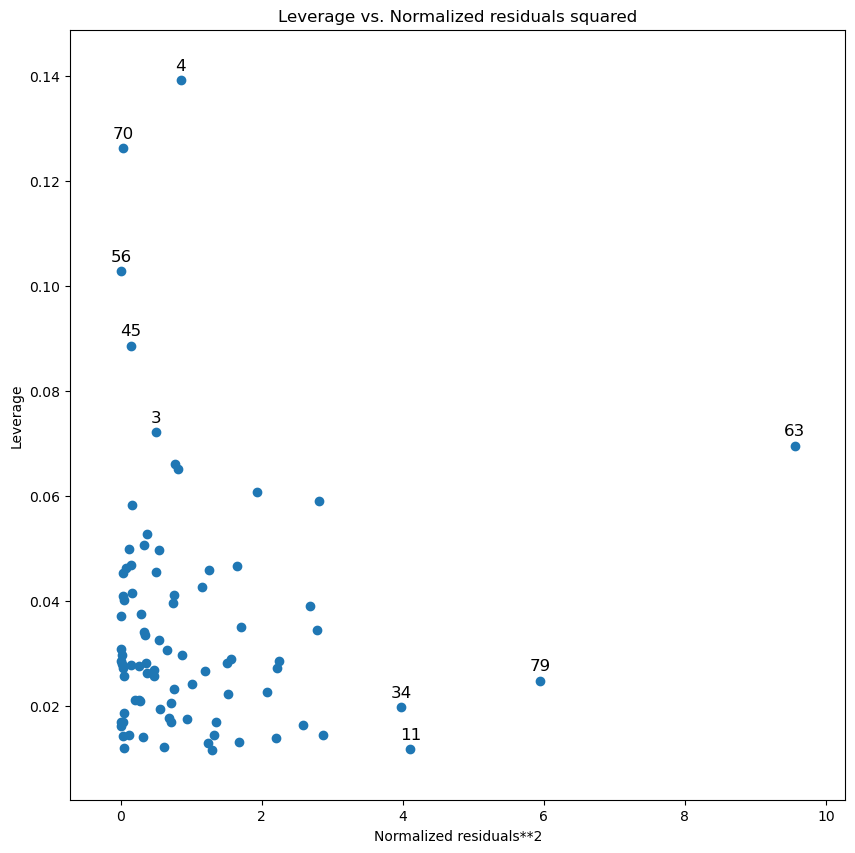

In [29]:
# Podemos también hacer un plot
fig, ax = plt.subplots(figsize=(10,10))

fit = plot_leverage_resid2(res_ols, ax=ax)

plt.show()

### Interpretación del gráfico

Este gráfico combina dos dimensiones clave del diagnóstico de regresión:

- **Eje Y**: Leverage (`hat values`)
  - Mide qué tan lejos está una observación del centro del espacio de predictores.
  - Valores altos indican que la observación tiene un perfil de predictores poco común.
  
- **Eje X**: Residuos studentizados (`studentized residuals`)
  - Miden cuánto se desvía una observación de su valor ajustado, estandarizado.
  - Valores grandes indican que la observación es un outlier en términos de la variable dependiente.

### ¿Cómo leer el gráfico?

- **Observaciones cercanas al origen (0,0)**: comunes, bien explicadas por el modelo.
- **Puntos con residuos grandes (muy arriba o muy abajo)**: posibles *outliers*.
- **Puntos con leverage alto (muy a la derecha)**: tienen influencia estructural en la estimación de los coeficientes.
- **Puntos que combinan ambos (alto leverage y alto residuo)**: son **potencialmente influyentes** y deben examinarse con métricas como la **Distancia de Cook**.

---

### Regla práctica

Observaciones en las esquinas superior derecha o inferior derecha del gráfico:

- Leverage alto + residuo grande = **alta influencia** en el modelo.
- Pueden distorsionar los coeficientes si no se tratan adecuadamente.

## Multicolinealidad

La **multicolinealidad** ocurre cuando dos o más variables independientes en un modelo de regresión están **altamente correlacionadas entre sí**, lo que genera redundancia en la información que aportan al modelo.

- Los coeficientes estimados se vuelven **inestables** y muy sensibles a pequeños cambios en los datos.
- Las **interpretaciones individuales** de los coeficientes se vuelven poco confiables.
- Los errores estándar de los coeficientes aumentan, lo que puede llevar a **valores p elevados** incluso si la variable es relevante.

Algunos efectos no deseados incluyen:

- Coeficientes con **signo inesperado**.
- Variables que deberían ser significativas aparecen como **no significativas**.
- **Cambios drásticos** en los coeficientes al agregar o quitar variables relacionadas.

La multicolinealidad no afecta necesariamente la calidad predictiva del modelo, pero **sí complica su interpretación**. Existen varios métodos para diagnosticarla:

### 1. Matriz de correlación
Una **alta correlación** entre dos predictores (por ejemplo, > 0.8 o < -0.8) puede ser indicio de multicolinealidad.

### 2. VIF (Variance Inflation Factor)

El **Factor de Inflación de la Varianza** mide cuánto aumenta la varianza del coeficiente estimado debido a la multicolinealidad.

\begin{equation}
\text{VIF}_j = \frac{1}{1 - R_j^2}
\end{equation}

Donde $R_j^2$ es el factor $R^2$ al predecir la variable $x_j$ con todas las demás.

- $\text{VIF} \approx 1$: No hay multicolinealidad.
- $\text{VIF} > 5$: Multicolinealidad moderada.
- $\text{VIF} > 10$: Multicolinealidad severa.

El número de condición de una matriz cuantifica qué tan cerca está de ser **singular** (es decir, no invertible). En regresión lineal, se aplica sobre la matriz $X$, que contiene las variables explicativas del modelo.

In [30]:
np.linalg.cond(res_ols.model.exog)

np.float64(702.1792145490066)

## Heterocedasticidad en regresión lineal

### Prueba de Breusch-Pagan para heterocedasticidad

La **prueba de Breusch-Pagan** (Breusch & Pagan, 1979) es una prueba estadística diseñada para detectar **heterocedasticidad** en los residuos de un modelo de regresión lineal.

Evalua si la **varianza de los errores** es constante (homocedasticidad) o cambia sistemáticamente con los valores de las variables explicativas (heterocedasticidad).

## Hipótesis nula y alternativa

- **$H_0$ (hipótesis nula):** Los errores tienen varianza constante (homocedasticidad).
- **$H_1$ (alternativa):** La varianza de los errores **depende de alguna o todas las variables explicativas** (heterocedasticidad).

La prueba se basa en un modelo auxiliar donde se ajusta una regresión de los **residuos al cuadrado** contra las variables explicativas:

\begin{equation}
\hat{\varepsilon}^2 = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \dots + \alpha_k x_k + u
\end{equation}

Si los coeficientes $\alpha$ son significativamente distintos de cero, se concluye que **la varianza de los errores depende de las variables predictoras**.

La función `sms.het_breuschpagan(resid, exog)` de `statsmodels` devuelve:

1. **LM statistic (Lagrange Multiplier)**: estadístico chi-cuadrado
2. **p-value**: asociado al LM
3. **F-value**: estadístico F del modelo auxiliar
4. **F p-value**: valor p asociado al F

In [33]:
name = ['Lagrange multiplier stat (ts)', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(res_ols.resid, res_ols.model.exog)

for element in lzip(name,test):
    print(element[0], '=', element[1])

Lagrange multiplier stat (ts) = 4.893213374094005
p-value = 0.08658690502352002
f-value = 2.5037159462564618
f p-value = 0.08794028782672814


El p-valor resulta en 0.08, por lo que se concluye con un nivel de significancia de 0.05 que no hay evidencia estadística para rechazar la hipótesis nula. No hay evidencia estadística para decir que no hay heterocedasticidad en los datos.

### Prueba de Goldfeld-Quandt para heterocedasticidad

La **prueba de Goldfeld-Quandt** es una prueba clásica para detectar **heterocedasticidad** en un modelo de regresión lineal, particularmente cuando se sospecha que la varianza de los errores **aumenta o disminuye** con alguna variable explicativa.

Evalua si existe un **cambio sistemático en la varianza** de los residuos a lo largo de una variable ordenada (generalmente alguna de las explicativas).

### Hipótesis nula y alternativa

- **$H_0$ (hipótesis nula):** Homocedasticidad (la varianza de los errores es constante).
- **$H_1$ (alternativa):** Heterocedasticidad (la varianza cambia entre dos subconjuntos del modelo).


1. Se **ordena** el conjunto de datos respecto a una variable (por default la primera).
2. Se **divide** el conjunto en dos partes (dejando de lado un grupo central si se desea).
3. Se ajustan dos modelos OLS, uno para cada grupo.
4. Se compara la **razón de las varianzas residuales** de ambos grupos con una prueba F.

\begin{equation}
F = \frac{S_2^2}{S_1^2}
\end{equation}

Donde:
- $S_1^2$: varianza de los residuos del primer grupo
- $S_2^2$: varianza del segundo grupo


In [34]:
name = ['F stat (ts)', 'p-value']
test = sms.het_goldfeldquandt(res_ols.resid, res_ols.model.exog)

for element in lzip(name,test):
    print(element[0], '=', element[1])

F stat (ts) = 1.1002422436378143
p-value = 0.38202950686925324


De igual manera, no hay evidencia estadística para decir que estos datos no tienen heterocedasticidad.

## Prueba de linealidad

### Prueba de Harvey-Collier 

La **prueba de Harvey-Collier** es una prueba estadística utilizada para detectar **violaciones del supuesto de linealidad** en modelos de regresión lineal ordinaria (OLS). Se basa en la idea de que si el modelo está bien especificado, los residuos no deben contener patrones no lineales.

Verifica si la relación entre la variable dependiente y las independientes es **lineal**, como lo exige el modelo OLS clásico.

### Hipótesis nula y alternativa

- **$H_0$ (hipótesis nula):** El modelo está correctamente especificado y la relación es lineal.
- **$H_1$ (alternativa):** El modelo está mal especificado; hay evidencia de **no linealidad**.

La prueba se basa en añadir una transformación **no lineal de los valores ajustados** al modelo (por ejemplo, su media recortada) y verificar si mejora significativamente el ajuste. Si la nueva variable es significativa, se interpreta como evidencia de **no linealidad**.

In [35]:
name = ['t statistic', 'p-value']
test = sms.linear_harvey_collier(res_ols)

for element in lzip(name,test):
    print(element[0], '=', element[1])

t statistic = -1.0796490077759802
p-value = 0.2834639247569222
